In [15]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
IMG_SIZE = 64
NUM_FRAMES = 10

In [8]:
def preprocess_video(video_path, num_frames=NUM_FRAMES):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    if frame_count == 0:
        print("Error: Video is empty or corrupted.")
        return None
    
    interval = max(1, frame_count // num_frames)
    
    for i in range(num_frames):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * interval)
        ret, frame = cap.read()
        if ret:
            frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
    
    cap.release()
    
    if len(frames) != num_frames:
        print("Error: Not enough frames extracted. Check video file.")
        return None
    
    frames = np.array(frames) / 255.0
    return frames.reshape(num_frames, IMG_SIZE, IMG_SIZE, 3)

# Data Analysis

In [9]:
def analyze_video_lengths(data_path):
    video_lengths = []
    
    for video_name in os.listdir(data_path):
        video_path = os.path.join(data_path, video_name)
        cap = cv2.VideoCapture(video_path)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        duration = frame_count / fps if fps > 0 else 0
        video_lengths.append(duration)
        cap.release()
        
    return video_lengths

In [10]:
violence_path = r"C:\Users\LEGION\Desktop\Violence Detection_O\Violence Detection\train_violence"
non_violence_path = r"C:\Users\LEGION\Desktop\Violence Detection_O\Violence Detection\train_non_violence"

In [11]:
violence_durations = analyze_video_lengths(violence_path)
non_violence_durations = analyze_video_lengths(non_violence_path)

## Plotting video length distributions

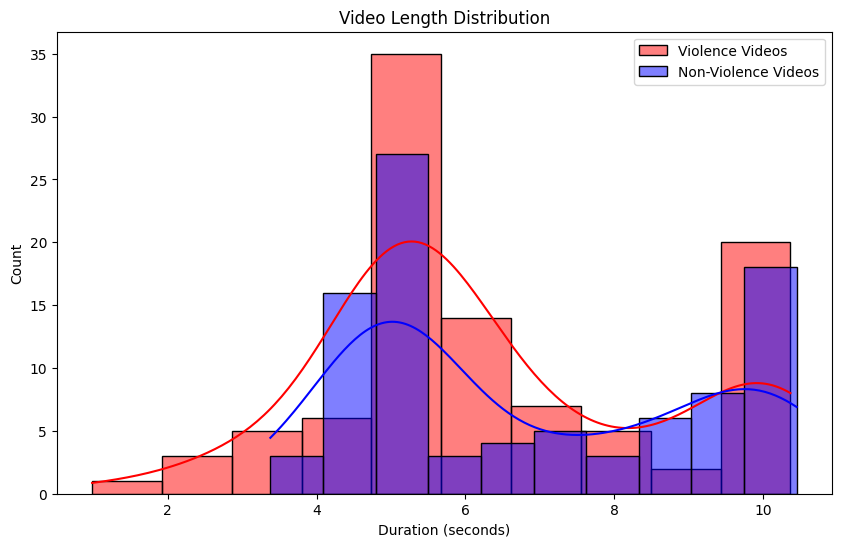

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(violence_durations, color='red', label='Violence Videos', kde=True, bins=10)
sns.histplot(non_violence_durations, color='blue', label='Non-Violence Videos', kde=True, bins=10)
plt.title('Video Length Distribution')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.legend()
plt.show()